# **| Canalisa - automatic detection and gating of anomalies**

### If anyone is reading this my name is Theo Cannam and I'm the author of this code. The name Canalisa is admittedly quite stupid. It's a play on my surname, LISA, and the word 'analyzer'. It's pronounced 'Canalyzer', because that's kind of what it does. This notebook is where I wrote and tested everything for my project, and now it serves as a little tutorial. It is intended for people with not much familiarity with TDI and machine learning. I hope someone finds it useful. 
<sub>(and if you want to build on this feel free to change the name)</sub>
<sub>(also see the end for my ideas on directions to take)</sub>

## **| Below: Imports, paths and parameters**

### **Required packages, paths to important locations in the codebase and some constants.** Here I will explain my choices behind these constants. Also all functions are documented so these descriptions along with those should hopefully be enough to catch one up to speed.

### LISA data has a sampling rate of 4 Hz (4 samples per second), and when getting the data we will downsample it to speed things up. I chose to downsample by 4x, meaning one sample corresponds to 1 second. That's an effective sampling rate of 1 Hz.
### I chose to split up the data into 2 minute windows, with an overlap of 75% (30s step). So for 1 day = 86400s = 2880 windows. More windows = more examples to train on.
### The anomalies we inject have a range of amplitudes. We want to be able to find just the loudest ones, and leave the quiet ones alone. I have labelled the bottom 20% of anomalies (by amplitude) as quiet, and the rest as loud.
### LISA TDI (time-delay interferometry) data has three channels (or variables) by default: X, Y and Z, and the data in each is different. Glitches and GWs in the actual interferometer data appear differently in X, Y and Z depending on where they came from. Mathematicians worked out other optimal combinations of these TDI variables that are useful. A, E and T are linear combinations of X, Y and Z, designed such that correlations between them are minimised. They are named after the inventors of TDI, Armstrong, Estabrook and Tinto.

In [6]:

import os
import h5py
import warnings
import numpy as np
import tensorflow as tf
from pathlib import Path
from scipy.ndimage import label
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import simpson
from scipy.signal import savgol_filter
from scipy.signal.windows import tukey
from numpy.lib.stride_tricks import sliding_window_view

cwd = Path().cwd()
PATH_bethLISA = cwd.parents[1]
PATH_tdi_data = PATH_bethLISA / "dist/lisa_data/tdi_data"
PATH_glitch_data = PATH_bethLISA / "dist/glitch/glitch_data"
PATH_gw_data = PATH_bethLISA / "dist/gw/gw_data"

tf.keras.mixed_precision.set_global_policy('mixed_float16')
tf.config.optimizer.set_jit(True)
warnings.filterwarnings('ignore')

downsample = 4
sampling_rate = 4 // downsample       
window_seconds = 120 
window_length = sampling_rate * window_seconds  
step_seconds = 30
step_size = sampling_rate * step_seconds   
label_threshold = 0.2
variables = "XYZ" #can be "XYZ" or "AET"


# **| Load Data**

### **Functions for loading the TDI data and labelling glitches and signals.**

### load_time_series_data() takes the name of the folder containing your data and outputs a numpy array of the data which we plot as a quick sanity check. The folders containing data are in dist/lisa_data/tdi_data. **Importantly**, it loops through *folders within the given folder* and joins each h5 file in those together, as a way of getting more training data without having to have generated like 50 days at once. If you want to join multiple files, currently they must each be 10 days long, as this is an assumption I have made to get the injection times in the resulting array correct. This can be changed in load_labels()

### load_labels() takes the name of the folder and loaded data and generates a binary mask that takes a value of 1 when a loud anomaly is present and 0 otherwise. **Importantly**, the necessary information is taken from .txt files in folders within dist/glitch/glitch_data or dist/gw/gw_data. The name of the folders in these is the same as the one containing the TDI data, so I can pass the same name to each function.

### We also print some useful information about the data you just loaded.

--===-- General --===-- ([])
Timeseries data shape ((2592000, 3))
Labels shape ((2592000, 2))
Are the injections in order? (False)
--===-- Glitches --===-- ([])
Glitch injection times ([434432, 589789, 815923, 643316, 349394, 269052, 636352, 221775, 195934, 189688, 249560, 5378, 81000, 329282, 163145, 681037, 96313, 681655, 332844, 769227, 549246, 736471, 650930, 438159, 842262, 234153, 796850, 539504, 115715, 324567, 241163, 196983, 105497, 605509, 579556, 165862, 36669, 370988, 723086, 772561, 631930, 275656, 167874, 757454, 306712, 670014, 835542, 231718, 222561, 558393, 694143, 762557, 259309, 22750, 143397, 155183, 450288, 729856, 51494, 309717, 112923, 308705, 758166, 446382, 574836, 586327, 233446, 819682, 546839, 78352, 413530, 759834, 353205, 510657, 130659, 272091, 340646, 601984, 56880, 225702, 485209, 313928, 347425, 320492, 340041, 137932, 788888, 465011, 432716, 421577, 541170, 516715, 357962, 251282, 378859, 750462, 172837, 735668, 217452, 846615, 438936, 449583, 794393,

(20000.0, 23000.0)

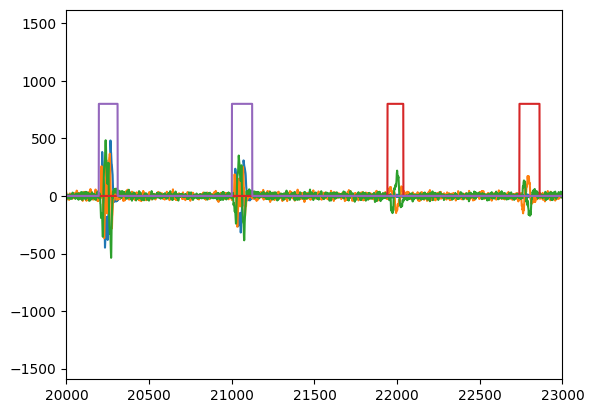

In [12]:

def normalise(timeseries):
    """
    Normalises timeseries data to [-1, 1].

    Arguments:
        timeseries: single channel timeseries data.

    Returns:
        normalised_timeseries: normalised single channel timeseries data.
    """
    minimum = timeseries.min(axis=0, keepdims=True)
    maximum = timeseries.max(axis=0, keepdims=True)
    return 2 * (timeseries - minimum) / (maximum - minimum + 1e-8) - 1

def load_time_series_data(folder, variables):
    """
    Loads TDI data, fetches glitch and gw injection times and loudness.

    Arguments:
        folder: name of TDI data folder. Data in any h5 file in any folder within this folder will be concatenated. I name these subfolders 
                with integers ascending from 1 when I have multiple simulations I want to join into one bigger one.

    Returns:
        data: TDI data of shape (seconds, 3)
        labels: binary feature labels of shape (seconds, 2): first array is 0 for every second with no glitch, 1 for every second with a glitch. 
                second array is 0 for every second with no GW, 1 for every second with a GW.
        glitch/gw_injection_times: start time of each glitch or gw in seconds, not ordered.
        glitch/gw_volumes: array containing 'loud' or 'quiet' for each injection based on its level.
    """

    tdi1, tdi2, tdi3 = [], [], []
    
    #READ TDI DATA TO SINGLE ARRAY FROM FILES
    for folder_path in sorted((f for f in os.listdir(os.path.join(PATH_tdi_data, folder)) if not f.startswith("."))):
        files = sorted((f for f in os.listdir(os.path.join(PATH_tdi_data, folder, folder_path)) if not f.startswith(".")))
        for fname in files:
            path = os.path.join(PATH_tdi_data, folder, folder_path, fname)
            with h5py.File(path, 'r') as hf:
                X = (hf['X'][:][::downsample])
                Y = (hf['Y'][:][::downsample])
                Z = (hf['Z'][:][::downsample])
                if variables == 'XYZ':
                    tdi1.append(X); tdi2.append(Y); tdi3.append(Z) 
                elif variables == 'AET':
                    tdi1.append((Z - X) / 2 ** 0.5)
                    tdi2.append((X - 2*Y + Z) / 6**0.5)
                    tdi3.append((X + Y + Z) / 3**0.5)

    data = (np.stack([np.concatenate(tdi1),np.concatenate(tdi2),np.concatenate(tdi3)], axis=-1))

    return data

def calc_duration(line):
    """
    Calculates the approximate duration of a FRED glitch using fsolve from scipy.

    Arguments:
        level: the value of the constant A premultiplying the FRED shape.
        t_rise, t_fall: the values of the t_rise and t_fall parameters defining the exponential rise and decay of the FRED shape.

    Returns: 
        duration of the disturbance in the TDI data in seconds.
    """

    time = int(float(line.split(' ')[1]))
    level = float(line.split(' ')[2])
    t_rise = int(float(line.split(' ')[3]))
    t_fall = int(float(line.split(' ')[4]))

    if t_rise != t_fall:
        #ANALYTIC MAXIMUM AMPLITUDE OF FRED GLITCH: T_RISE != T_FALL
        g_max = (level / (t_rise - t_fall)) * ((t_rise / t_fall) ** (t_fall / (t_fall - t_rise)) - (t_rise / t_fall) ** (t_rise / (t_fall - t_rise)))
        t_max = ( ( t_rise * t_fall ) / ( t_fall - t_rise ) ) * np.log( t_rise / t_fall )
        guess = t_max + 50 #FIRST GUESS USED BY NUMERICAL APPROXIMATION ALGORITHM FSOLVE. CHOOSE A POINT AFTER THE PEAK SO IT FINDS THE RIGHT TIME.
        #FRED SHAPE:
        def g_FRED(t):
            return ( level / (t_rise - t_fall) ) * ( np.exp( -t / t_rise) - np.exp( -t / t_fall))
        #EQUATION TO FIND ROOTS OF: - WHEN G_MAX IS 1/30TH OF ITS PEAK (THIS OCCURS ONCE BEFORE THE PEAK AND ONCE AFTER. WE WANT THE LATTER TIME)
        def want_roots(t): 
            return g_FRED(t) - g_max/30
        #APPROXIMATE THE SOLUTION:
        t = fsolve(want_roots, guess)[0]

    elif t_rise == t_fall:
        #ANALYTIC MAXIMUM: T_RISE = T_FALL
        g_max_2 = (level) / (t_fall * np.exp(1))
        t_max_2 = t_fall
        guess_2 = t_max_2 + 50
        #FRED CONTINUOUS EXTENSION SHAPE
        def g_FRED_2(t):
            return ( level * (t / (t_fall ** 2)) * np.exp( -t / t_fall))
        #EQUATION TO FIND ROOTS OF
        def want_roots_2(t):
            return g_FRED_2(t) - g_max_2/30
        #APPROXIMATE THE SOLUTION
        t = fsolve(want_roots_2, guess_2)[0]

    return int(np.round(t) + 4*8)

def calc_amplitude(line):
    """
    Used by load_labels to get peak heights of glitches and gws. Both use the FRED shape, for which the maximum was simple to work out.

    Arguments:
        line: line of glitch / gw data txt file. Contains  shape, level, t_rise, t_fall I think.

    Returns:
        amp: peak height of glitch or gw
    """

    level = float(line.split(' ')[2])
    t_rise = int(float(line.split(' ')[3]))
    t_fall = int(float(line.split(' ')[4]))


    if t_rise != t_fall:
        amp = (level / (t_rise - t_fall)) * ((t_rise / t_fall) ** (t_fall / (t_fall - t_rise)) - (t_rise / t_fall) ** (t_rise / (t_fall - t_rise)))
    elif t_rise == t_fall:
        amp = (level) / (t_fall * np.exp(1))
    
    return amp 

def load_labels(folder, data, threshold):
    """
    Gets list of injection times, amplitudes and approximate durations of all injected anomalies. Generates the binary label mask for the 
    U-Net using the anomaly times and durations. Anomalies with an amplitude above a certain threshold (currently the median, so half) are
    labelled, the rest are not.

    The output 'labels' can be thought of in two ways: as 2 timeseries, where each second is labelled with a single boolean (glitch/no glitch for
    channel 1, gw/no gw for channel 2) or as one timeseries, where each second is labelled with a 2-dimensional vector that encodes for 
    that particular second whether a glitch only, a gw only, both or neither are present. These are the same.

    Arguments:
        folder: name of folder containing glitch data and gw data. These should have the same name. For simplicity I use the same name 
                as the TDI data folder. Data in any txt file in any folder within this folder will be concatenated. I name these subfolders
                with integers ascending from 1 when I have multiple simulations I want to join into one bigger one.
    Returns:
        labels: array-like, shape: (seconds, 2). 
        stats: dictionary of useful information about the data.
        + lotsa other stuff:
            labels: binary feature labels of shape (seconds, 2): first array is 0 for every second with no glitch, 1 for every second with a glitch. 
                    second array is 0 for every second with no GW, 1 for every second with a GW.
            glitch/gw_injection_times: array of start times of each glitch or gw in seconds (not in order).
            glitch/gw_amps: array of amplitudes of each glitch or gw. 
            glitch/gw_durations: array of durations of each glitch or gw in seconds.
            glitch/gw_volumes: array containing true or false for each injection based on its amplitude. Uses the label_threshold parameter to
                                decide above which amplitude they should be labelled 'loud'. Loud injections appear in the label mask 'labels'.
    """

    glitch_amps, gw_amps = [], []
    glitch_volumes, gw_volumes = [], []
    glitch_durations, gw_durations = [], []
    glitch_injection_times, gw_injection_times = [], []

    t0 = 10368000
    i=0
    j=0

    for folder_path in sorted((f for f in os.listdir(os.path.join(PATH_glitch_data, folder)) if not f.startswith("."))):
        files = sorted((f for f in os.listdir(os.path.join(PATH_glitch_data, folder, folder_path)) if f.endswith(".txt")))

        for fname in files:

            path = os.path.join(PATH_glitch_data, folder, folder_path, fname)
            f = open(path, 'r')
            glitch_output = f.readlines()

            for line in glitch_output:

                duration = calc_duration(line)
                time = int(float(line.split(' ')[1]))
                amp = calc_amplitude(line)
                sorted_time = int(sampling_rate*(10*i*86400+(time-t0))) #10 here is 10 days because the data in each file is 10 days long. 

                glitch_amps.append(amp)
                glitch_durations.append(duration)
                glitch_injection_times.append(sorted_time)
 
            f.close()
            i+=1
        

    for folder_path in sorted((f for f in os.listdir(os.path.join(PATH_gw_data, folder)) if not f.startswith("."))):
        files = sorted((f for f in os.listdir(os.path.join(PATH_gw_data, folder, folder_path)) if f.endswith(".txt")))

        for fname in files:

            path = os.path.join(PATH_gw_data, folder, folder_path, fname)
            f = open(path, 'r')
            gw_output = f.readlines()

            for line in gw_output:
    
                duration = calc_duration(line)
                amp = calc_amplitude(line)
                time = int(float(line.split(' ')[1]))
                sorted_time = int(sampling_rate*(10*j*86400+(time-t0)))

                gw_injection_times.append(sorted_time)
                gw_durations.append(duration)
                gw_amps.append(amp)

            f.close()
            j+=1
    
    labels = np.zeros((data.shape[0],2))

    thresh_glitch = np.percentile(glitch_amps,threshold*100)
    thresh_gw = np.percentile(gw_amps,threshold*100)

    for time in range(len(glitch_injection_times)):
        if glitch_amps[time] > thresh_glitch:
            try:
                labels[glitch_injection_times[time]-10:glitch_injection_times[time]+glitch_durations[time],0] = 1
                glitch_volumes.append(True)
            except IndexError:
                pass
        else:
            glitch_volumes.append(False)
    
    for time in range(len(gw_injection_times)):
        if gw_amps[time] > thresh_gw:
            try:
                labels[gw_injection_times[time]-10:gw_injection_times[time]+gw_durations[time],1] = 1
                gw_volumes.append(True)
            except IndexError:
                pass
        else:
            gw_volumes.append(False)


    stats = {
        '--===-- General --===--': [],
        'Timeseries data shape': data.shape,
        'Labels shape': labels.shape,
        'Are the injections in order?': glitch_injection_times == sorted(glitch_injection_times) and gw_injection_times == sorted(gw_injection_times),
        '--===-- Glitches --===--': [],
        'Glitch injection times': glitch_injection_times,
        'Number of glitches': len(glitch_injection_times),
        'Glitch durations': glitch_durations,
        'Glitch amplitudes': glitch_amps,
        'Glitch loud': np.count_nonzero(glitch_volumes),
        'Glitch quiet': len(glitch_volumes)-np.count_nonzero(glitch_volumes),
        '--===-- GWs --===--': [],
        'GW injection times': gw_injection_times,
        'Number of GWs': len(gw_injection_times),
        'GW durations': gw_durations,
        'GW amplitudes': gw_amps,
        'GW loud': np.count_nonzero(gw_volumes),
        'GW quiet': len(gw_volumes)-np.count_nonzero(gw_volumes)
    }

    return labels, stats, glitch_injection_times, gw_injection_times, glitch_amps, gw_amps, glitch_durations, gw_durations, glitch_volumes, gw_volumes
    
def print_stats(stats):
    """
    Prints the contents of the stats dictionary in a nice format.
    """
    for key, info in stats.items():  
        print("{} ({})".format(key, info))


train_data = load_time_series_data(folder="30d50apd", variables=variables)

train_labels, train_stats, glitch_injection_times, gw_injection_times, glitch_amps, gw_amps, glitch_durations, gw_durations, glitch_volumes, gw_volumes = load_labels(folder="30d50apd", data=train_data, threshold=label_threshold)

print_stats(train_stats)

plt.plot(train_data)
plt.plot(train_labels*800)
plt.xlim(20000, 23000)

# **| Split into windows & build model**

### **Now we put the array data into a tensorflow dataset, shuffled into windows of length window_length. We also compile the model.**

### For training, we need both the TDI data and the binary label mask we generated earlier to learn from. The tf.data.Dataset object takes both of these, splits them up into windows and shuffles them around. Then we build the model using one of the model building functions and use model.summary() to see what the architecture looks like. 
### Later we will run model.fit() on our model with the tf.data.Dataset as the training data. This is what does the training. We are compiling with 'Precision' and 'Recall' metrics, which will tell us how well it is doing during training.

In [3]:
def train_dataset_from_data(data, labels, window_length, step_size):
    """
    Slices the train data and labels into windows of length window_length and overlap determined by step_size. I.e. if window_length == step_size,
    there is no overlap.

    Arguments: 
        data: train data. Shape (seconds, 3)
        labels: train labels. Shape (seconds, 2)
        window_length: length of desired windows in seconds.
        step_size: step between start times of windows in seconds.

    Reeturns:
        dataset: tf.data.Dataset object. Shuffled, labelled windows of TDI data to train the U-Net on.
    """

    data_wins = sliding_window_view(train_data, window_length, axis=0)[::step_size].transpose(0,2,1)
    label_wins = sliding_window_view(train_labels, window_length, axis=0)[::step_size].transpose(0,2,1)

    y = label_wins
    X = data_wins                   

    #CREATE TF DATASET
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(buffer_size=1000).batch(8).prefetch(tf.data.AUTOTUNE)

    return dataset

train_dataset = train_dataset_from_data(data=train_data, labels=train_labels, window_length=window_length, step_size=step_size)

def build_unet_1d(window_length, channels=3):
    """
    Builds U-Net architecture. Slower version.

    Arguments:
        window_length: length of windows input to the U-Net in seconds.
        channels: number of channels of input to the U-Net in seconds.
    Returns:
        tf.keras.Model()
    """
    #INPUT
    inp = tf.keras.Input((window_length, channels))

    #ENCODER
    c1 = tf.keras.layers.Conv1D(32, 3, padding='same')(inp)
    a1 = tf.keras.layers.Activation('relu')(c1)
    p1 = tf.keras.layers.MaxPooling1D(2)(a1)

    c2 = tf.keras.layers.Conv1D(64, 3, padding='same')(p1)
    a2 = tf.keras.layers.Activation('relu')(c2)
    p2 = tf.keras.layers.MaxPooling1D(2)(a2)

    #BOTTLENECK
    c3 = tf.keras.layers.Conv1D(128, 3, padding='same')(p2)
    a3 = tf.keras.layers.Activation('relu')(c3)

    #DECODER
    u1 = tf.keras.layers.UpSampling1D(2)(a3)
    concat1 = tf.keras.layers.Concatenate()([u1, c2])
    c4 = tf.keras.layers.Conv1D(64, 3, padding='same')(concat1)
    a4 = tf.keras.layers.Activation('relu')(c4)

    u2 = tf.keras.layers.UpSampling1D(2)(a4)
    concat2 = tf.keras.layers.Concatenate()([u2, c1])
    c5 = tf.keras.layers.Conv1D(32, 3, padding='same')(concat2)
    a5 = tf.keras.layers.Activation('relu')(c5)
    drop = tf.keras.layers.Dropout(0.5)(a5)

    #OUTPUT
    last = tf.keras.layers.Conv1D(2, 1, padding='same')(drop)
    out = tf.keras.layers.Activation('sigmoid', name='class_prob')(last)
    return tf.keras.Model(inp, out, name="U-Net")

def build_fast_unet_1d(window_length, channels=3):
    """
    Builds U-Net architecture. Faster version

    Arguments:
        window_length: length of windows input to the U-Net in seconds.
        channels: number of channels of input to the U-Net in seconds.
    Returns:
        tf.keras.Model()
    """   
    inp = tf.keras.Input((window_length, channels))
    # ENCODER
    def enc_block(x, filters):
        x = tf.keras.layers.SeparableConv1D(filters, 3, padding='same')(x)
        x = tf.keras.layers.Activation('relu')(x)
        p = tf.keras.layers.MaxPooling1D(2)(x)
        return x, p

    c1, p1 = enc_block(inp, 32)
    c2, p2 = enc_block(p1, 64)

    # BOTTLENECK
    b = tf.keras.layers.SeparableConv1D(128, 3, padding='same', dilation_rate=2)(p2)
    b = tf.keras.layers.Activation('relu')(b)

    # DECODER
    def dec_block(x, skip, filters):
        x = tf.keras.layers.UpSampling1D(2)(x)
        x = tf.keras.layers.Concatenate()([x, skip])
        x = tf.keras.layers.SeparableConv1D(filters, 3, padding='same')(x)
        x = tf.keras.layers.Activation('relu')(x)
        return x

    u1 = dec_block(b, c2, 64)
    u2 = dec_block(u1, c1, 32)

    drop = tf.keras.layers.Dropout(0.5)(u2)
    out = tf.keras.layers.Conv1D(2, 1, activation='sigmoid', name='class_prob')(drop)
    return tf.keras.Model(inp, out, name="Fast1D_UNet")

model = build_fast_unet_1d(window_length, channels=3)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.Precision(name='prec'),
             tf.keras.metrics.Recall(name='rec')]
)

model.summary()

Model: "Fast1D_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 120, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d    │ (None, 120, 32)   │        137 │ input_layer[0][0] │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 120, 32)   │          0 │ separable_conv1d… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 60, 32)    │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d_1  │ (None, 60, 64)    │      2,208 │ max_pooling1d[0]… │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 60, 64)    │          0 │ separable_conv1d… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 30, 64)    │          0 │ activation_1[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d_2  │ (None, 30, 128)   │      8,512 │ max_pooling1d_1[… │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 30, 128)   │          0 │ separable_conv1d… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 60, 128)   │          0 │ activation_2[0][… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 60, 192)   │          0 │ up_sampling1d[0]… │
│ (Concatenate)       │                   │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d_3  │ (None, 60, 64)    │     12,928 │ concatenate[0][0] │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 60, 64)    │          0 │ separable_conv1d… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d_1     │ (None, 120, 64)   │          0 │ activation_3[0][… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 120, 96)   │          0 │ up_sampling1d_1[… │
│ (Concatenate)       │                   │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d_4  │ (None, 120, 32)   │      3,392 │ concatenate_1[0]… │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 120, 32)   │          0 │ separable_conv1d

 Total params: 27,243 (106.42 KB)

 Trainable params: 27,243 (106.42 KB)

 Non-trainable params: 0 (0.00 B)

# **| Train**

### Now we run model.fit(). Epochs is the number of passes it does. More epochs *should* lead to better predictive power, but to an extent. After many epochs the precision will stop increasing, and it isnt worth it to keep going.

### If we are happy with the model, we can save the whole thing. The architecture, plus everything it learned during training are saved to a .keras file. I trained one on XYZ data and one on AET data to see if there was a difference. There isn't really. 

### If you dont want to wait a long time to train you can load the previously saved model.

In [4]:
model.fit(train_dataset, epochs=25)

# #SAVE MODEL WITH CORRESPONDING NAME
# if variables = "XYZ":
#     model.save('CanalisaXYZ.keras')
# elif variables = "AET":
#     model.save('CanalisaAET.keras')

# #LOAD PREVIOUSLY SAVED MODEL
# model = tf.keras.models.load_model('CanalisaAET.keras')

Epoch 1/25
10800/10800 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 0.1061 - prec: 0.7531 - rec: 0.6212
Epoch 2/25
10800/10800 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 0.0429 - prec: 0.9183 - rec: 0.8129
Epoch 3/25
10800/10800 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 0.0389 - prec: 0.9291 - rec: 0.8263
Epoch 4/25
10800/10800 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 0.0365 - prec: 0.9367 - rec: 0.8353
Epoch 5/25
10800/10800 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 0.0354 - prec: 0.9409 - rec: 0.8402
Epoch 6/25
10800/10800 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 0.0344 - prec: 0.9440 - rec: 0.8438
Epoch 7/25
10800/10800 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 0.0335 - prec: 0.9452 - rec: 0.8466
Epoch 8/25
10800/10800 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - loss: 0.0332 - prec: 0.9470 - rec: 0.8488
Epoch 9/25
10800/10800 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - loss: 0.0325 - prec: 0.9469 - rec: 0.8523
Epoch 10/25
10800/10800 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - loss: 0.0321 - prec: 0.9482 - r

# **| Test**

### Here we load a fresh, *independent* set of TDI data and pass that to a tf dataset, except this time without labels. Inference() runs model.predict() on the dataset, and combines the output probability masks for each window (with accumulate_predictions()) to a single long one for the whole time series. 

In [7]:
def accumulate_predictions(data_len, preds, step_size, window_length):
    """
    Pieces together the predicted masks from each window after running inference on them.

    Arguments:
        data_len: total length of the data in seconds.
        preds: Output from model.predict() on the dataset. I.e. the model's predicted masks.
        step_size: step between start times of windows in seconds.
        window_length: window length in seconds.

    Returns:
        scores: The accumulated predictions. Shape (seconds, 2). Note these are affected by repeated counts of overlapping windows.
        counts: Shape (seconds, 2). Number of times each sample has been counted due to overlapping windows. Used to get correct predictions from scores.
    """
    scores = np.zeros((data_len, 2), dtype=np.float32)
    counts = np.zeros((data_len, 2), dtype=np.int32)
    #LOOP OVER WINDOWS, i IS WINDOW NUMBER, PROB HAS SHAPE (window_length, 2)
    for i, prob in enumerate(preds):
        start = i * step_size
        #ADD MASK FROM WINDOW TO SCORES ARRAY
        scores[start:start+window_length] += prob
        #COUNT HOW MANY TIMES THIS WINDOW AS BEEN COVERED TO COMPUTE CORRECT AVERAGES
        counts[start:start+window_length] += 1
    return scores, counts

test_data = load_time_series_data(folder='1d50apd_test_tdi_data', variables=variables)

test_labels, test_stats, test_glitch_injection_times, test_gw_injection_times, test_glitch_amps, test_gw_amps, test_glitch_durations, test_gw_durations, test_glitch_volumes, test_gw_volumes = load_labels(folder='1d50apd_test_tdi_data', data=test_data, threshold=label_threshold)

print_stats(test_stats)

def test_dataset_from_data(data, window_length, step_size):
    """
    Slices test data into windows to run inference on. Similar to train_dataset_from_data except labels are not needed.

    Arguments:
        data: test data. shape (seconds, 3)
        window_length: length of windows in seconds.
        step_size: step between start times of windows in seconds.
    
    Returns:
        test_ds: tf.data.Dataset object. Unshuffled, unlabelled windows of TDI data to perform inference on.
    """
    test_wins = sliding_window_view(data, window_length, axis=0)[::step_size].transpose(0,2,1)
    test_ds = (tf.data.Dataset.from_tensor_slices(test_wins).batch(8).prefetch(tf.data.AUTOTUNE))
    return test_ds

def inference(data, smoothing):
    """
    Generates a predicted GW and glitch mask for a set of test data.

    Arguments:
        data: TDI data we want to do predictions for.
        smoothing: Integer > 0, determines how smooth the mask is. Larger number = more smoothing. I tend to use 50 to 100.
    
    Returns: 
        glitch_mask: Shape (seconds). Array between 0 and 1. Represents probability of glitch at any given second.
        gw_mask: Shape (seconds). Array between 0 and 1. Represents probability of GW at any given second.
    """
    dataset = test_dataset_from_data(data=data, window_length=window_length, step_size=step_size)

    preds = model.predict(dataset, verbose=1)

    scores, counts = accumulate_predictions(len(data), preds, step_size, window_length)

    average_mask = scores / np.maximum(counts, 1)

    glitch_mask = savgol_filter(average_mask[:,0], smoothing, 4)
    gw_mask = savgol_filter(average_mask[:,1], smoothing, 4)

    return glitch_mask, gw_mask

test_glitch_mask, test_gw_mask = inference(data=test_data, smoothing=100)


--===-- General --===-- ([])
Timeseries data shape ((86400, 3))
Labels shape ((86400, 2))
Are the injections in order? (False)
--===-- Glitches --===-- ([])
Glitch injection times ([63525, 9001, 51417, 13797, 32471, 83962, 26414, 59403, 66209, 22700, 47433, 1715, 71405, 5790, 17802, 56844, 33699, 31705, 54475, 78449, 75950, 19908, 40586, 56219, 62878, 37807, 53858, 42440, 53262, 11951, 48100, 35867, 7994, 44930, 28573, 27818, 24998, 82721, 77342, 50878, 76578, 75409, 66896, 37276, 23326, 85824, 62314, 86191])
Number of glitches (48)
Glitch durations ([116, 129, 126, 85, 108, 121, 119, 113, 90, 126, 117, 94, 70, 100, 90, 91, 104, 93, 107, 104, 121, 116, 82, 108, 76, 107, 110, 79, 115, 79, 108, 116, 108, 115, 113, 104, 106, 130, 141, 101, 106, 76, 92, 117, 80, 95, 73, 86])
Glitch amplitudes ([24.719072292380535, 39.31920843784447, 3.629155558100515, 200.77794821968126, 34.90217080073238, 30.84412609312125, 44.775725100995665, 76.79855826008958, 41.86085281512948, 101.4548007463556, 18.02

# **| Extract events from mask & visualise predictions**

### Here we plot the output of the prediction. Dashed lines are the true glitch and GW labels. Solid red and blue curves are the probability mask. Both of these are just arrays of numbers between 0 and 1, but they're scaled up for visualisation purposes.

### extract_events() uses the probability mask to give a score to successive windows of length big_len. The score goes between -infinity and zero. Any window with a score above log_threshold is shaded on the plot and the start and end times put in a list.

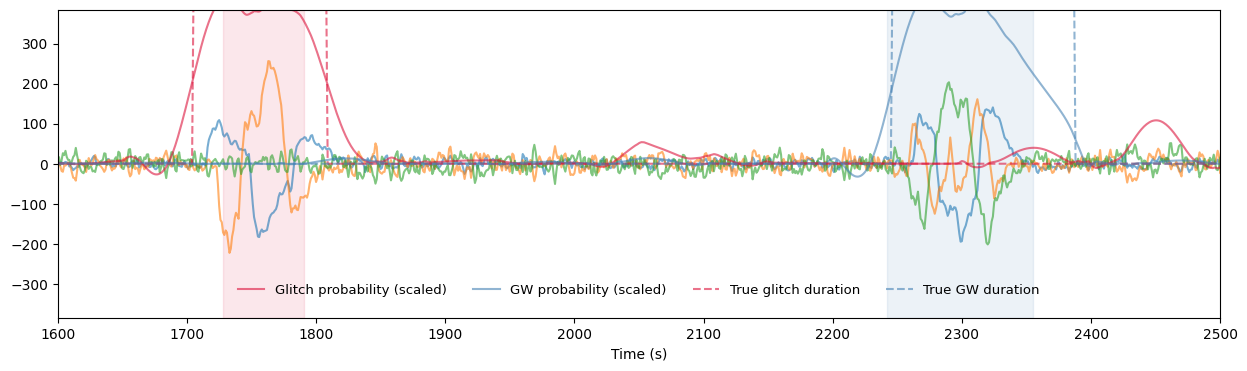

[(1728, 1791), (9024, 9055), (11968, 12031), (13792, 13887), (17792, 17887), (19936, 19999), (22688, 22783), (23328, 23423), (24992, 25055), (26432, 26463), (27808, 27903), (28576, 28639), (31712, 31775), (33696, 33791), (35872, 35967), (37280, 37343), (40608, 40671), (42432, 42495), (44928, 44991), (48128, 48159), (50880, 50975), (53248, 53311), (53856, 53951), (54496, 54559), (56224, 56287), (56864, 56959), (59392, 59487), (62304, 62399), (62880, 62943), (66208, 66239), (66912, 66975), (71424, 71487), (75392, 75487), (75936, 76031), (76576, 76671), (83968, 83999), (85824, 85919), (86208, 86271)]
[-0.15106656577569663, -1.7737909334421085, -0.3134674301396111, -1.7067688882404841, -1.769862449602788, -1.675766096370404, -0.9639443881383198, -0.9234009830453802, -0.5484076943093995, -2.580394890612246, -0.7566058129153004, -0.4017548135927542, -0.326667305529043, -0.8322591050074429, -0.5605369566900067, -0.6421266472254352, -0.5018913853217625, -0.7150145081338043, -0.7780654857959921

In [ ]:

def extract_events(mask, small_len, big_len, log_threshold, eps = 1e-9, merge_adjacent = True):
    """
    Give scores between -inf and 0 to windows of data based on likelihood of anomaly from probability mask and return times and confidence
    of predicted anomalies from this.

    Arguments:
        mask: probability mask (from inference())
        small_len: stride (or size, since there is no overlap) of small windows over the mask, calculating 
                   the mean of the window.
        big_len: stride of big windows over the small windows. Calculates the sum of the log of each small window.

    Returns:
        segments: list of dicts with start_idx, end_idx (inclusive, in samples/seconds),
                  start_small, end_small (indices in small-windows),
                  start_big, end_big (indices in big-windows),
                  and scores for each big window included.
        times: list of (start, end) tuples of windows containing predicted anomalies. 
        confidences: scores of predicted windows. If multiple passing windows in succession, average score is given.
    """

    mask = np.asarray(mask, dtype=float)
    N = mask.shape[0]

    # MEANS OVER SMALL WINDOWS
    n_small = N // small_len
    if n_small == 0:
        return []
    trimmed = mask[: n_small * small_len]
    small_windows = trimmed.reshape(n_small, small_len)
    small_means = small_windows.mean(axis=1)  

    # LOGS OVER BIG WINDOWS
    n_big = n_small // big_len
    if n_big == 0:
        return []
    trimmed_small = small_means[: n_big * big_len]
    big_windows = trimmed_small.reshape(n_big, big_len)
    scores = np.log(np.clip(big_windows, eps, 1.0)).sum(axis=1)  # CLIP TO AVOID INFINITY

    # THRESHOLD
    passing = scores >= log_threshold  

    segments = []
    times = []
    confidences = []

    i = 0
    while i < n_big:
        if not passing[i]:
            i += 1
            continue

        
        j = i
        while j + 1 < n_big and passing[j + 1] and merge_adjacent:
            j += 1

        # MAP WINDOW INDICES BACK TO SAMPLE INDICES TO GET THE CORRECT TIMES
        start_small = i * big_len
        end_small = (j + 1) * big_len - 1  

        start_idx = start_small * small_len
        end_idx = (end_small + 1) * small_len - 1 

        seg_scores = scores[i : j + 1].copy()

        segments.append({
            "start_idx": int(start_idx),
            "end_idx":   int(end_idx),
            "start_small": int(start_small),
            "end_small":   int(end_small),
            "start_big":   int(i),
            "end_big":     int(j),
            "big_window_scores": seg_scores,
            "min_score": float(seg_scores.min()),
            "max_score": float(seg_scores.max()),
            "mean_score": float(seg_scores.mean()),
        })

        times.append((int(start_idx), int(end_idx)))
        confidences.append(seg_scores.mean())
        

        i = j + 1

    return times, confidences

test_glitch_events, glitch_scores = extract_events(mask=test_glitch_mask,
                                            small_len=2,
                                            big_len=16,
                                            log_threshold=-4.0)

test_gw_events, gw_scores = extract_events(mask=test_gw_mask,
                                        small_len=2,
                                        big_len=19,
                                        log_threshold=-7.0)

def visualise_inference(data, labels, glitch_mask, gw_mask, glitch_events, gw_events, start, end):
    """
    Plots a selected region of TDI data, overlayed with the predicted masks (solid red & blue), true labels (dotted red & blue) 
    and shaded with predicted regions. Red = glitch, Blue = GW

    Arguments:
        data: test TDI data.
        labels: test TDI labels.
        glitch_mask, gw_mask: glitch and gw probability masks.
        glitch_events, gw_events: predicted glitch and gw event time tuples. 
        start, end: times to plot between.
    
    Returns: plot
    """
    time = np.arange(len(data)) / sampling_rate

    # Plot signals & regions
    plt.figure(figsize=(15,4))

    #SCALE Y LIMITS FOR READABILITY
    ylim = [-1.5*np.max(data[start:end]), 1.5*np.max(data[start:end])]
    #APPLY LIMITS
    plt.xlim(start, end)
    plt.ylim(ylim[0], ylim[1])

    plt.plot(data, alpha=0.6)

    plt.plot(glitch_mask*ylim[1], color='crimson', label='Glitch probability (scaled)', alpha=0.6)
    plt.plot(gw_mask*ylim[1], color='steelblue', label='GW probability (scaled)', alpha=0.6)

    plt.plot(labels[:,0]*ylim[1], color='crimson', linestyle='--', label='True glitch duration', alpha=0.6)
    plt.plot(labels[:,1]*ylim[1], color='steelblue', linestyle='--', label='True GW duration', alpha=0.6)

    for s,e in glitch_events: plt.axvspan(s, e, color='crimson', alpha=0.1)
    for s,e in gw_events: plt.axvspan(s, e, color='steelblue', alpha=0.1)

    plt.xlabel('Time (s)')

    plt.legend(ncol=6, bbox_to_anchor=(0.5, 0.15), loc='upper center', frameon=False, prop={'size':9.5})

    plt.show()

visualise_inference(data=test_data, 
                    labels=test_labels, 
                    gw_mask=test_gw_mask,
                    glitch_mask=test_glitch_mask, 
                    glitch_events=test_glitch_events, 
                    gw_events=test_gw_events, 
                    start=1600, 
                    end=2500
                    )

print(test_glitch_events)

print(glitch_scores)

# | **Check Performance**

### We get the number of correct detections, incorrect detections, and missed loud anomalies, and plot the first example of each for glitches and GWs, to see what could be going wrong and might need adjusting.

Glitches: {'TP_loud': 37, 'TN_quiet': 9, 'FP_quiet': 1, 'FP_none': 0, 'FN_loud': 1}
GWs: {'TP_loud': 41, 'TN_quiet': 6, 'FP_quiet': 5, 'FP_none': 0, 'FN_loud': 0}
-No FPN, skipping plot
-No FPN, skipping plot
-No FNL, skipping plot


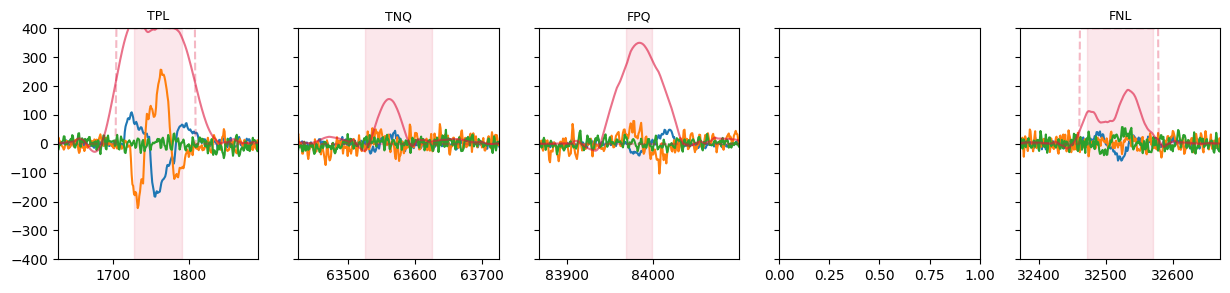

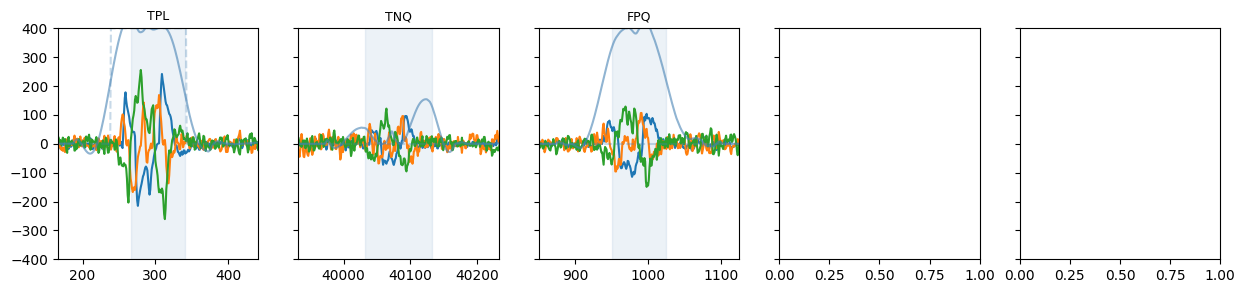

In [9]:
def evaluate_detections(injection_times, injection_volumes, detection_regions, type):
    """
    Compares true glitch injections to detected regions.

    Arguments:
        injection_times: 1D array-like of floats, times of all injected glitches.
        injection_volumes: array-like of same length, each true or false depending on whether they were labelled as loud or not.
        detection_regions: list of (start, end) tuples defining detected glitch intervals.
        type: 'Glitches' or 'GWs' just used for understandability when printing lol

    Returns:
        eval_totals: dict with counts:
            'TP_loud': correct detections of loud glitches
            'TN_quiet': correct misses of quiet glitches.
            'FP_quiet': false detections overlapping only quiet glitches
            'FP_none': false detections overlapping no glitches
            'FN_loud': missed loud glitches (not covered by any detection)

        eval: dict with arrays:
            'TPL': (start, end) tuples of true positive detections.
            'TNQ': injection times of true negatives of quiet anomalies.
            'FPQ': (start, end) tuples of false positive detections of quiet anomalies
            'FPN': (start, end) tuples of false positive detections of nothing.
            'FNL': injection times of false negatives of loud anomalies.
    """

    injection_times = np.asarray(injection_times)
    injection_volumes = np.asarray(injection_volumes)
    

    evaluation = {
        'TPL': [],
        'TNQ': [],
        'FPQ': [],
        'FPN': [],
        'FNL': []
        }


    #FIND TRUE LOUD DETECTIONS, FALSE QUIET DETECTIONS AND FALSE NOISE DETECTIONS
    for start, end in detection_regions:
        in_region = (injection_times >= start-60) & (injection_times <= end+60)
        if np.any(in_region & (injection_volumes == True)):
            evaluation['TPL'].append((start,end))
        elif np.any(in_region & (injection_volumes == False)):
            evaluation['FPQ'].append((start,end))
        else:
            evaluation['FPN'].append((start,end))

    #FIND FALSE MISSES OF LOUD GLITCHES
    loud_times = injection_times[injection_volumes == True]
    for t in loud_times:
        if not any((start-60 <= t <= end+60) for start, end in detection_regions):
            evaluation['FNL'].append((t, t+100))
            
    #FIND TRUE MISSES OF QUIET GLITCHES
    quiet_times = injection_times[injection_volumes == False]
    for t in quiet_times:
        if not any((start-60 <= t <= end+60) for start, end in detection_regions):
            evaluation['TNQ'].append((t, t+100))

    eval_totals = {
        'TP_loud': len(evaluation['TPL']),
        'TN_quiet': len(evaluation['TNQ']),
        'FP_quiet': len(evaluation['FPQ']),
        'FP_none': len(evaluation['FPN']),
        'FN_loud': len(evaluation['FNL'])
    }

    print(f'{type}: {eval_totals}')

    return eval_totals, evaluation

test_glitch_eval_totals, test_glitch_eval = evaluate_detections(injection_times=test_glitch_injection_times, 
                                                                injection_volumes=test_glitch_volumes, 
                                                                detection_regions=test_glitch_events, 
                                                                type='Glitches'
                                                                )
                                                                
test_gw_eval_totals, test_gw_eval = evaluate_detections(injection_times=test_gw_injection_times, 
                                                        injection_volumes=test_gw_volumes, 
                                                        detection_regions=test_gw_events, 
                                                        type='GWs'
                                                        )

def plot_confusion(data, labels, glitch_mask, gw_mask, glitch_eval, gw_eval):
    """
    Plots the first example of each category in the data, to visualise the causes of any undesirable predictions.

    Arguments:
        data, labels: test TDI data and labels
        glitch_mask, gw_mask: prediction masks for glitches and gws
        glitch_eval, gw_eval: evaluation dictionaries for glitches and gws (from evaluate_detections()).
    
    Returns:
        plots
    """
    #INITIALISE PLOT
    fig, axes = plt.subplots(1,5, sharey=True, figsize=(15,3))
    categories = ['TPL', 'TNQ', 'FPQ', 'FPN', 'FNL']

    #LOOP OVER AXES, ONE FOR EACH CATEGORY AND SKIP EMPTY ONES
    for ax, category in zip(axes, categories):
        limits = glitch_eval.get(category, [])

        if not glitch_eval.get(category):
            print(f'-No {category}, skipping plot')
            continue

        start, end = limits[0]

        ax.set_title(category,size=9)
        ax.set_xlim(start-100, end+100)
        ax.set_ylim(-400,400)
        ax.plot(data)
        ax.plot(glitch_mask*400, color='crimson', label='Glitch probability (scaled)', alpha=0.6)
        ax.plot(labels[:,0]*400, color='crimson', label='True Duration', alpha=0.3, linestyle='--')
        ax.axvspan(start, end, color='crimson', alpha=0.1)

    fig2, axes = plt.subplots(1,5, sharey=True, figsize=(15,3))

    #LOOP OVER AXES, ONE FOR EACH CATEGORY AND SKIP EMPTY ONES
    for ax, category in zip(axes, categories):
        limits = gw_eval.get(category, [])

        if not gw_eval.get(category):
            print(f'-No {category}, skipping plot')
            continue

        start, end = limits[0]

        ax.set_title(category,size=9)
        ax.set_xlim(start-100, end+100)
        ax.set_ylim(-400, 400)
        ax.plot(data)
        ax.plot(gw_mask*400, color='steelblue', label='GW probability (scaled)', alpha=0.6)
        ax.plot(labels[:,1]*400, color='steelblue', label='True Duration', alpha=0.3, linestyle='--')
        ax.axvspan(start, end, color='steelblue', alpha=0.1)

    plt.show()

plot_confusion(data=test_data, 
               labels=test_labels,
               glitch_mask=test_glitch_mask,
               gw_mask=test_gw_mask,
               glitch_eval=test_glitch_eval, 
               gw_eval=test_gw_eval
               )

# **| Gating**

### We take the start and end times of all detections and taper them to zero using a tukey window. I use 120s of padding on either side. gate() takes the original data you want to gate, the detected glitch event times and the detected gw event times and returns the fixed data.

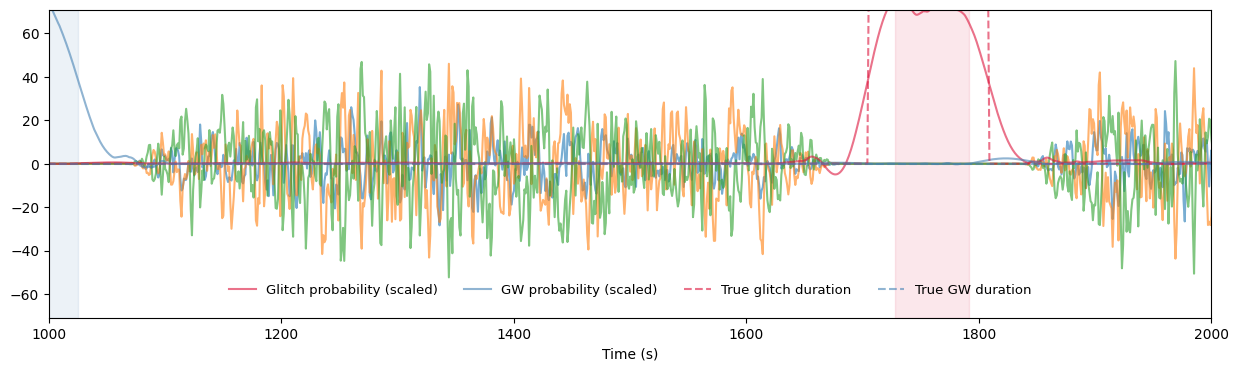

In [10]:
def gate(data, glitch_where, gw_where, roundedness):
    """
    Tapers regions within and around detected anomalies to zero.

    Arguments:
        data: TDI data to gate
        glitch_where, gw_where: arrays of (start, end) tuples of predicted glitch and gw detection times for the corresponding TDI data.
        roundedness: how steep the tukey window is. Using 0.5 generally.

    Returns:
        gated_data: TDI data with anomalous regions set to zero.
    """

    where = glitch_where + gw_where
    gated_data = data.copy()
    for start, end in where:
        npoints = (240+end-start)
        window = tukey(npoints, alpha=roundedness)
        try:
            for i in range(3): gated_data[start-120:end+120, i] *= (1-window)
        except ValueError:
            pass

    return gated_data

gated_data = gate(data=test_data, glitch_where=test_glitch_events, gw_where=test_gw_events, roundedness=0.5)

visualise_inference(data=gated_data, 
                    labels=test_labels, 
                    gw_mask=test_gw_mask,
                    glitch_mask=test_glitch_mask, 
                    glitch_events=test_glitch_events, 
                    gw_events=test_gw_events, 
                    start=1000, 
                    end=2000
                    )


# **| Inference on gated data**

### Here I wanted to do pass the gated data back into the model to see if it finds any loud glitches again. I'm not sure what I really expected to learn from this. 

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


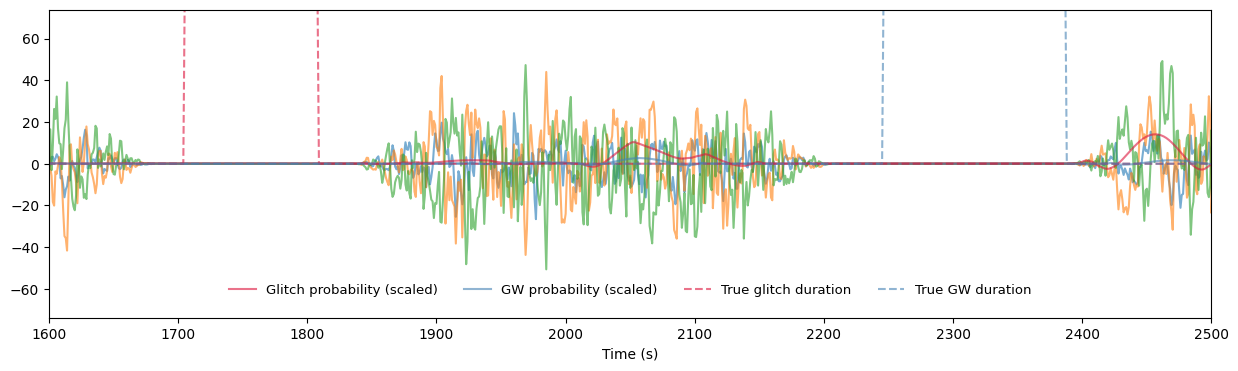

Number of loud glitches found: 0
Number of loud GWs found: 0


In [11]:

gated_glitch_mask, gated_gw_mask = inference(data=gated_data, smoothing=100)

gated_glitch_events, gated_glitch_scores = extract_events(mask=gated_glitch_mask,
                                            small_len=5,
                                            big_len=11,
                                            log_threshold=-11)

gated_gw_events, gated_gw_scores = extract_events(mask=gated_gw_mask,
                                        small_len=4,
                                        big_len=13,
                                        log_threshold=-5.0)

visualise_inference(data=gated_data, 
                    labels=test_labels, 
                    gw_mask=gated_gw_mask, 
                    glitch_mask=gated_glitch_mask,
                    glitch_events=gated_glitch_events,
                    gw_events=gated_gw_events, 
                    start=1600, 
                    end=2500
                    )

print(f'Number of loud glitches found: {len(gated_glitch_events)}')
print(f'Number of loud GWs found: {len(gated_gw_events)}')

# **| Find best threshold and minimum duration for maximising true detections** (I didn't write this)

### This code goes through every reasonable combination of small_len, big_len and log_threshold and find the one that best maximises the true positive rate (TPR) while minimising the false positive rate (FPR) but with a preference towards the former. (More concerned with ensuring we remove all loud glitches, even if it means we remove some quiet ones as well)

### Note to self: make sure to do this after training and saving weights for the last time. The best values are probably most closely related to the precision and recall achieved 

In [28]:
# TEST: Optimise detection threshold 

import numpy as np


def get_TPR(mask, small_len, big_len, log_threshold, inj_times, volumes):
    events, confidences = extract_events(mask=mask,
                                        small_len=small_len,
                                        big_len=big_len,
                                        log_threshold=log_threshold
                                        )

    evaltotals, eval = evaluate_detections(injection_times=inj_times, 
                                injection_volumes=volumes, 
                                detection_regions=events, 
                                type='Glitches'
                                )


    tpl = evaltotals.get('TP_loud')
    fnl = evaltotals.get('FN_loud')

    fpq = evaltotals.get('FP_quiet')
    tnq = evaltotals.get('TN_quiet')
    
    tpr = tpl / (tpl+fnl)
    fpr = fpq / (fpq+tnq)

    return tpr, fpr

#function to minimise
def objective(log_threshold, small_len, big_len):
    tpr, fpr = get_TPR(test_glitch_mask, small_len, big_len, log_threshold, test_glitch_injection_times, test_glitch_volumes)
    return 1-tpr, fpr



thetas = np.arange(-20, -1, dtype=int)          
ks = np.arange(1, 11, dtype=int)
gs = np.arange(10, 20, dtype=int)

# search ranges
thetas = np.arange(-20, 0)   
ks     = np.arange(1, 12)  
gs     = np.arange(10, 21)  

# evaluate all candidates
cands = []
for th in thetas:
    for k in ks:
        for g in gs:
            f1, f2 = objective(th, k, g)
            cands.append((f1, f2, th, k, g))
cands = np.array(cands, dtype=float) 


F = cands[:, :2]
mins = F.min(axis=0)
rngs = np.maximum(F.max(axis=0) - mins, 1e-12)
Fn = (F - mins) / rngs


def pick_weighted_sum(w1=0.8):
    w2 = 1.0 - w1
    scores = w1*Fn[:, 0] + w2*Fn[:, 1]
    i = int(np.argmin(scores))
    return dict(theta=int(cands[i, 2]), 
                k=int(cands[i, 3]), 
                g=int(cands[i, 4]),
                f1=float(cands[i, 0]), 
                f2=float(cands[i, 1]),
                w1=w1, w2=w2)


best = pick_weighted_sum(w1=0.9)

print("Best (weighted sum, f1 priority):")
print(f"  theta={best['theta']}, k={best['k']}, g={best['g']}")
print(f"  f1={best['f1']:.6f}, f2={best['f2']:.6f}  (w1={best['w1']:.2f}, w2={best['w2']:.2f})")

Glitches: {'TP_loud': 201, 'TN_quiet': 9, 'FP_quiet': 43, 'FP_none': 354, 'FN_loud': 0}
Glitches: {'TP_loud': 198, 'TN_quiet': 10, 'FP_quiet': 40, 'FP_none': 236, 'FN_loud': 0}
Glitches: {'TP_loud': 196, 'TN_quiet': 10, 'FP_quiet': 39, 'FP_none': 178, 'FN_loud': 0}
Glitches: {'TP_loud': 193, 'TN_quiet': 12, 'FP_quiet': 37, 'FP_none': 126, 'FN_loud': 0}
Glitches: {'TP_loud': 191, 'TN_quiet': 15, 'FP_quiet': 35, 'FP_none': 92, 'FN_loud': 0}
Glitches: {'TP_loud': 189, 'TN_quiet': 16, 'FP_quiet': 33, 'FP_none': 68, 'FN_loud': 0}
Glitches: {'TP_loud': 190, 'TN_quiet': 17, 'FP_quiet': 32, 'FP_none': 54, 'FN_loud': 0}
Glitches: {'TP_loud': 189, 'TN_quiet': 19, 'FP_quiet': 30, 'FP_none': 37, 'FN_loud': 0}
Glitches: {'TP_loud': 188, 'TN_quiet': 19, 'FP_quiet': 30, 'FP_none': 26, 'FN_loud': 0}
Glitches: {'TP_loud': 188, 'TN_quiet': 21, 'FP_quiet': 28, 'FP_none': 17, 'FN_loud': 0}
Glitches: {'TP_loud': 188, 'TN_quiet': 24, 'FP_quiet': 24, 'FP_none': 15, 'FN_loud': 0}
Glitches: {'TP_loud': 197, 'T

### Ideas for future work?
* whiten & normalise data? 

* improve understandability of detection score? (i.e. in order to act as a probability or false alarm rate (FAR)?) 

* eventually could a model identify type of glitch or physical properties of GW signals? (don't see why not if our simulation capabilities improve and we can get enough examples to train on) (question asked by aryamann)

* train and test on other glitch shapes and gw shapes. so far I have used only the FRED shape (fast rise exponential decay) using william's code. Both glitches and GWs have been modelled as this shape but look different once in TDI data. 

* test what happens with overlapping anomalies: i.e. a case where the labels for such samples are like [1, 1] rather than just [1, 0] or [0, 1] or neither. I would hypothesise that it would still be gated fine. Can also train on this sort of data. Overlapping signals and glitches are realistic and expected as far as I am aware, so it would be good to look at.

* come up with some transformations that could improve performance? like the whitening and normalization above or maybe adapt load_timeseries_data() to take any three TDI variables like as an array instead of a string and test which ones work best. like variables = [X, E, A] for example? I'm not sure if that would even make sense mathematically.

* adapt Canalyze.py to take the folder and desired TDI variables as command-line arguments.